# Flight Delay Predictions for Capstone Project 2

Here we try to predict the number of minutes that a flight will be late.  The idea is the day before a flight a person can use the predictor to determine if their flight will be delayed.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from catboost import CatBoostRegressor, Pool
from datetime import datetime
from scipy.stats import t
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Imputer, scale
from sklearn.svm import SVR

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [3]:
filenames = glob('Data/20*.csv')

In [4]:
list_df = [pd.read_csv(f,header=0,low_memory=False,parse_dates=['FlightDate']) 
           for f in filenames]

# Data Wrangling

### Import the datasets removing data that doesn't apply before concatenating

In [5]:
new_list_df = []

In [6]:
# pull in the datasets and reduce them to only include flights that start at Dulles Airport
for i in list_df:
    j = i[i['Origin'] == 'IAD'].reset_index(drop=True)
    new_list_df.append(j)

In [7]:
# concatenate all the datasets now that they have been reduced
dfFlight = pd.concat(new_list_df,ignore_index=True)

### Take a quick look at the data before we start making changes

In [8]:
dfFlight.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2014,1,1,27,1,2014-01-27,DL,19790,DL,N989DL,301,12264,1226402,30852,IAD,"Washington, DC",VA,51,Virginia,38,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,955,953.0,-2.0,0.0,0.0,-1.0,0900-0959,11.0,1004.0,1128.0,6.0,1149,1134.0,-15.0,0.0,0.0,-1.0,1100-1159,0.0,NaN,0.0,114.0,101.0,84.0,1.0,534.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,1,1,24,5,2014-01-24,DL,19790,DL,N358NB,1697,12264,1226402,30852,IAD,"Washington, DC",VA,51,Virginia,38,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,740,737.0,-3.0,0.0,0.0,-1.0,0700-0759,12.0,749.0,908.0,8.0,936,916.0,-20.0,0.0,0.0,-2.0,0900-0959,0.0,NaN,0.0,116.0,99.0,79.0,1.0,534.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,1,1,26,7,2014-01-26,DL,19790,DL,N905DL,558,12264,1226402,30852,IAD,"Washington, DC",VA,51,Virginia,38,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,740,746.0,6.0,6.0,0.0,0.0,0700-0759,4.0,750.0,915.0,5.0,938,920.0,-18.0,0.0,0.0,-2.0,0900-0959,0.0,NaN,0.0,118.0,94.0,85.0,1.0,534.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,1,26,7,2014-01-26,DL,19790,DL,N954DL,1125,12264,1226402,30852,IAD,"Washington, DC",VA,51,Virginia,38,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1443,1437.0,-6.0,0.0,0.0,-1.0,1400-1459,15.0,1452.0,1615.0,5.0,1635,1620.0,-15.0,0.0,0.0,-1.0,1600-1659,0.0,NaN,0.0,112.0,103.0,83.0,1.0,534.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,1,1,26,7,2014-01-26,DL,19790,DL,N965DL,1172,12264,1226402,30852,IAD,"Washington, DC",VA,51,Virginia,38,10397,1039705,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,1210,1208.0,-2.0,0.0,0.0,-1.0,1200-1259,13.0,1221.0,1347.0,7.0,1405,1354.0,-11.0,0.0,0.0,-1.0,1400-1459,0.0,NaN,0.0,115.0,106.0,86.0,1.0,534.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [9]:
dfFlight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235303 entries, 0 to 235302
Columns: 110 entries, Year to Unnamed: 109
dtypes: datetime64[ns](1), float64(70), int64(20), object(19)
memory usage: 197.5+ MB


In [10]:
dfFlight = dfFlight[dfFlight['Origin'] == 'IAD'].reset_index(drop=True)

### Lots of columns only apply to events that happen after an aircraft has departed.  We will drop all of those

In [11]:
drop_list = ['Year','Quarter','DOT_ID_Reporting_Airline','IATA_CODE_Reporting_Airline','OriginAirportID',
             'OriginAirportSeqID','OriginCityMarketID','OriginCityName','OriginStateFips','OriginStateName','OriginWac',
             'DestAirportID','DestAirportSeqID','DestCityMarketID','DestCityName','DestStateFips','DestStateName',
             'DestWac','DepTime','DepDelayMinutes','DepDel15','DepartureDelayGroups','TaxiOut','WheelsOff','WheelsOn',
             'TaxiIn','CRSArrTime','ArrTime','ArrDelay','ArrDelayMinutes','ArrDel15','ArrivalDelayGroups','ArrTimeBlk',
             'Diverted','ActualElapsedTime','AirTime','Flights','DistanceGroup','CarrierDelay','WeatherDelay','NASDelay',
             'SecurityDelay','LateAircraftDelay','FirstDepTime','TotalAddGTime','LongestAddGTime','DivAirportLandings',
             'DivReachedDest','DivActualElapsedTime','DivArrDelay','DivDistance','Div1Airport','Div1AirportID',
             'Div1AirportSeqID','Div1WheelsOn','Div1TotalGTime','Div1LongestGTime','Div1WheelsOff','Div1TailNum',
             'Div2Airport','Div2AirportID','Div2AirportSeqID','Div2WheelsOn','Div2TotalGTime','Div2LongestGTime',
             'Div2WheelsOff','Div2TailNum','Div3Airport','Div3AirportID','Div3AirportSeqID','Div3WheelsOn',
             'Div3TotalGTime','Div3LongestGTime','Div3WheelsOff','Div3TailNum','Div4Airport','Div4AirportID',
             'Div4AirportSeqID','Div4WheelsOn','Div4TotalGTime','Div4LongestGTime','Div4WheelsOff','Div4TailNum',
             'Div5Airport','Div5AirportID','Div5AirportSeqID','Div5WheelsOn','Div5TotalGTime','Div5LongestGTime',
             'Div5WheelsOff','Div5TailNum','Unnamed: 109','CRSDepTime']
dfFlight = dfFlight.drop(drop_list, axis=1)

### Cancelled flight don't have a specific delay associated with them so they will not fit into our analysis

In [12]:
dfFlight = dfFlight[dfFlight['Cancelled'] == 0].reset_index(drop=True)

In [13]:
drop_list = ['Cancelled','CancellationCode']
dfFlight = dfFlight.drop(drop_list, axis=1)

### Get rid of any rows that do not have data for the Departure Delay

In [14]:
# check for null values in Departure Delay
dfFlight["DepDelay"].isnull().sum()

30

In [15]:
dfFlight = dfFlight.dropna(subset=['DepDelay']).reset_index(drop=True)

In [16]:
# check that all null Departure Delays have been removed
dfFlight['DepDelay'].isnull().sum()

0

### Change the Days and Months to categorical data instead of linear data

In [17]:
dfFlight['DayOfWeek'] = np.where(dfFlight['DayOfWeek'] == 1,'Monday',dfFlight['DayOfWeek'])
dfFlight['DayOfWeek'] = np.where(dfFlight['DayOfWeek'] == '2','Tuesday',dfFlight['DayOfWeek'])
dfFlight['DayOfWeek'] = np.where(dfFlight['DayOfWeek'] == '3','Wednesday',dfFlight['DayOfWeek'])
dfFlight['DayOfWeek'] = np.where(dfFlight['DayOfWeek'] == '4','Thursday',dfFlight['DayOfWeek'])
dfFlight['DayOfWeek'] = np.where(dfFlight['DayOfWeek'] == '5','Friday',dfFlight['DayOfWeek'])
dfFlight['DayOfWeek'] = np.where(dfFlight['DayOfWeek'] == '6','Saturday',dfFlight['DayOfWeek'])
dfFlight['DayOfWeek'] = np.where(dfFlight['DayOfWeek'] == '7','Sunday',dfFlight['DayOfWeek'])

In [18]:
dfFlight['Month'] = np.where(dfFlight['Month'] == 1,'Jan',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '2','Feb',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '3','Mar',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '4','Apr',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '5','May',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '6','Jun',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '7','Jul',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '8','Aug',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '9','Sep',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '10','Oct',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '11','Nov',dfFlight['Month'])
dfFlight['Month'] = np.where(dfFlight['Month'] == '12','Dec',dfFlight['Month'])

In [19]:
dfFlight.head()

,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,Dest,DestState,DepDelay,DepTimeBlk,CRSElapsedTime,Distance
0,Jan,27,Monday,2014-01-27,DL,N989DL,301,IAD,VA,ATL,GA,-2.0,0900-0959,114.0,534.0
1,Jan,24,Friday,2014-01-24,DL,N358NB,1697,IAD,VA,ATL,GA,-3.0,0700-0759,116.0,534.0
2,Jan,26,Sunday,2014-01-26,DL,N905DL,558,IAD,VA,ATL,GA,6.0,0700-0759,118.0,534.0
3,Jan,26,Sunday,2014-01-26,DL,N954DL,1125,IAD,VA,ATL,GA,-6.0,1400-1459,112.0,534.0
4,Jan,26,Sunday,2014-01-26,DL,N965DL,1172,IAD,VA,ATL,GA,-2.0,1200-1259,115.0,534.0


## Read in the weather data to add to the observations

In [20]:
dfWX = pd.read_csv('Data/WX.csv',header=0,low_memory=False,parse_dates=['DATE'])

In [21]:
dfWX.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",38.93486,-77.44728,88.4,2014-01-01,4.47,0.00,0.0,0.0,33,46,23,150,210.0,12.1,16.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",38.93486,-77.44728,88.4,2014-01-02,4.70,0.36,3.0,0.0,33,37,28,360,360.0,14.1,18.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",38.93486,-77.44728,88.4,2014-01-03,12.97,0.00,0.0,3.1,23,29,9,320,320.0,31.1,44.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",38.93486,-77.44728,88.4,2014-01-04,6.71,0.00,0.0,2.0,18,32,8,200,210.0,23.0,25.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00093738,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",38.93486,-77.44728,88.4,2014-01-05,2.91,0.23,0.0,1.2,29,37,24,140,140.0,13.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
dfWX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 25 columns):
STATION      1826 non-null object
NAME         1826 non-null object
LATITUDE     1826 non-null float64
LONGITUDE    1826 non-null float64
ELEVATION    1826 non-null float64
DATE         1826 non-null datetime64[ns]
AWND         1826 non-null float64
PRCP         1826 non-null float64
SNOW         1826 non-null float64
SNWD         1826 non-null float64
TAVG         1826 non-null int64
TMAX         1826 non-null int64
TMIN         1826 non-null int64
WDF2         1826 non-null int64
WDF5         1820 non-null float64
WSF2         1826 non-null float64
WSF5         1820 non-null float64
WT01         751 non-null float64
WT02         104 non-null float64
WT03         173 non-null float64
WT04         26 non-null float64
WT05         5 non-null float64
WT06         18 non-null float64
WT08         107 non-null float64
WT09         4 non-null float64
dtypes: datetime64[ns](1), float64(

In [23]:
drop_list = ['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION']
dfWX = dfWX.drop(drop_list, axis=1)

### Merge all the data based on the dates

In [24]:
# merge the data based on the flight date from the flight information and the date of the weather observation
df = dfFlight.merge(dfWX, left_on='FlightDate', right_on='DATE')

In [25]:
df.head()

,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,Dest,DestState,DepDelay,DepTimeBlk,CRSElapsedTime,Distance,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,Jan,27,Monday,2014-01-27,DL,N989DL,301,IAD,VA,ATL,GA,-2.0,0900-0959,114.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jan,27,Monday,2014-01-27,DL,N343NB,1697,IAD,VA,ATL,GA,70.0,0700-0759,116.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Jan,27,Monday,2014-01-27,DL,N919DL,2015,IAD,VA,ATL,GA,-4.0,1600-1659,114.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Jan,27,Monday,2014-01-27,DL,N906DL,2260,IAD,VA,ATL,GA,-3.0,1800-1859,116.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Jan,27,Monday,2014-01-27,DL,N972DL,1125,IAD,VA,ATL,GA,-2.0,1400-1459,112.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df.isnull().sum()

Month                                   0
DayofMonth                              0
DayOfWeek                               0
FlightDate                              0
Reporting_Airline                       0
Tail_Number                             0
Flight_Number_Reporting_Airline         0
Origin                                  0
OriginState                             0
Dest                                    0
DestState                               0
DepDelay                                0
DepTimeBlk                              0
CRSElapsedTime                          0
Distance                                0
DATE                                    0
AWND                                    0
PRCP                                    0
SNOW                                    0
SNWD                                    0
TAVG                                    0
TMAX                                    0
TMIN                                    0
WDF2                              

### The null values are all from the weather observation types.  We can fill those with 0 if they weren't observed.

In [27]:
# Using SimpleImputer to fill in the nan values with a constant, zero.  
imp_con = SimpleImputer(strategy='constant',fill_value=0)

In [28]:
df.iloc[:,24:35].head()

,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,330.0,31.1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df.iloc[:,24:35] = imp_con.fit_transform(df.iloc[:,24:35])

In [30]:
df.isnull().sum()

Month                              0
DayofMonth                         0
DayOfWeek                          0
FlightDate                         0
Reporting_Airline                  0
Tail_Number                        0
Flight_Number_Reporting_Airline    0
Origin                             0
OriginState                        0
Dest                               0
DestState                          0
DepDelay                           0
DepTimeBlk                         0
CRSElapsedTime                     0
Distance                           0
DATE                               0
AWND                               0
PRCP                               0
SNOW                               0
SNWD                               0
TAVG                               0
TMAX                               0
TMIN                               0
WDF2                               0
WDF5                               0
WSF2                               0
WSF5                               0
W

In [31]:
df.head()

,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,Dest,DestState,DepDelay,DepTimeBlk,CRSElapsedTime,Distance,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,Jan,27,Monday,2014-01-27,DL,N989DL,301,IAD,VA,ATL,GA,-2.0,0900-0959,114.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jan,27,Monday,2014-01-27,DL,N343NB,1697,IAD,VA,ATL,GA,70.0,0700-0759,116.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jan,27,Monday,2014-01-27,DL,N919DL,2015,IAD,VA,ATL,GA,-4.0,1600-1659,114.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Jan,27,Monday,2014-01-27,DL,N906DL,2260,IAD,VA,ATL,GA,-3.0,1800-1859,116.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Jan,27,Monday,2014-01-27,DL,N972DL,1125,IAD,VA,ATL,GA,-2.0,1400-1459,112.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
out_csv = 'Data/Data_Clean.csv'
df.to_csv(out_csv)

In [33]:
#df = pd.read_csv('Data/Data_Clean.csv',low_memory=False,index_col=0,parse_dates=['DATE','FlightDate'])

# Data Story

### We will visualize average delay vs day of week, time of day, tail number

In [34]:
df.head()

,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,Dest,DestState,DepDelay,DepTimeBlk,CRSElapsedTime,Distance,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,Jan,27,Monday,2014-01-27,DL,N989DL,301,IAD,VA,ATL,GA,-2.0,0900-0959,114.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jan,27,Monday,2014-01-27,DL,N343NB,1697,IAD,VA,ATL,GA,70.0,0700-0759,116.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jan,27,Monday,2014-01-27,DL,N919DL,2015,IAD,VA,ATL,GA,-4.0,1600-1659,114.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Jan,27,Monday,2014-01-27,DL,N906DL,2260,IAD,VA,ATL,GA,-3.0,1800-1859,116.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Jan,27,Monday,2014-01-27,DL,N972DL,1125,IAD,VA,ATL,GA,-2.0,1400-1459,112.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df.groupby('DayOfWeek').mean().DepDelay.sort_values()

DayOfWeek
Sunday        9.773557
Saturday     10.834474
Tuesday      11.204741
Wednesday    11.498558
Monday       11.860524
Thursday     12.315103
Friday       12.530377
Name: DepDelay, dtype: float64

### We can see that the biggest delays actually happen on the weekdays, peaking on Friday.  This is a graph of the average delay for each day of the week.

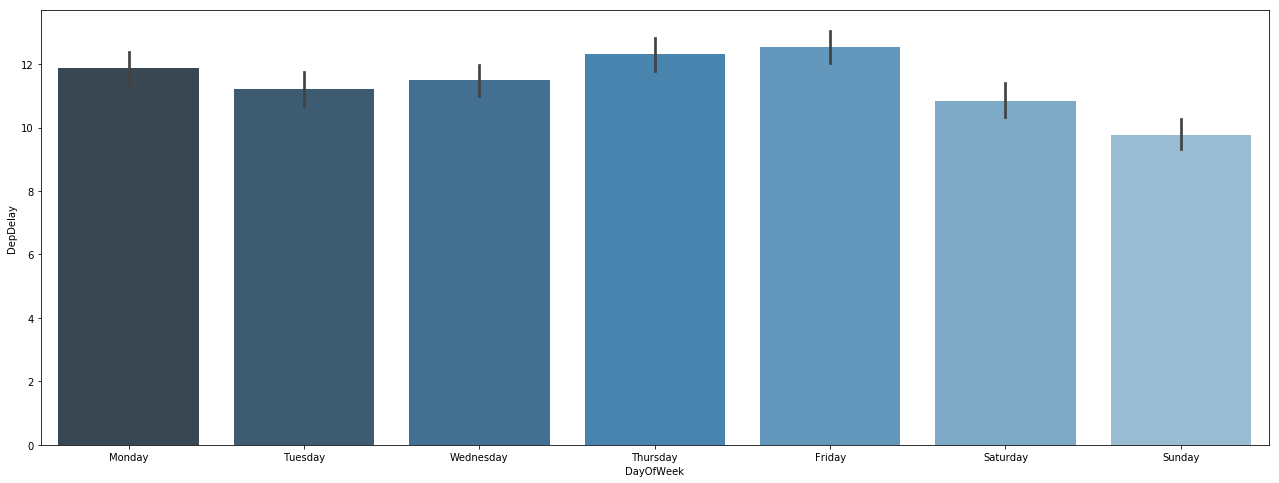

In [36]:
plt.figure(figsize=(22,8))
ax = sns.barplot(x="DayOfWeek", y="DepDelay", data=df, order=['Monday','Tuesday','Wednesday',
                                                              'Thursday','Friday','Saturday','Sunday'], palette="Blues_d")

### We can also see that the biggest delays happen in June and July.  I would have expected Nov and Dec to be bigger

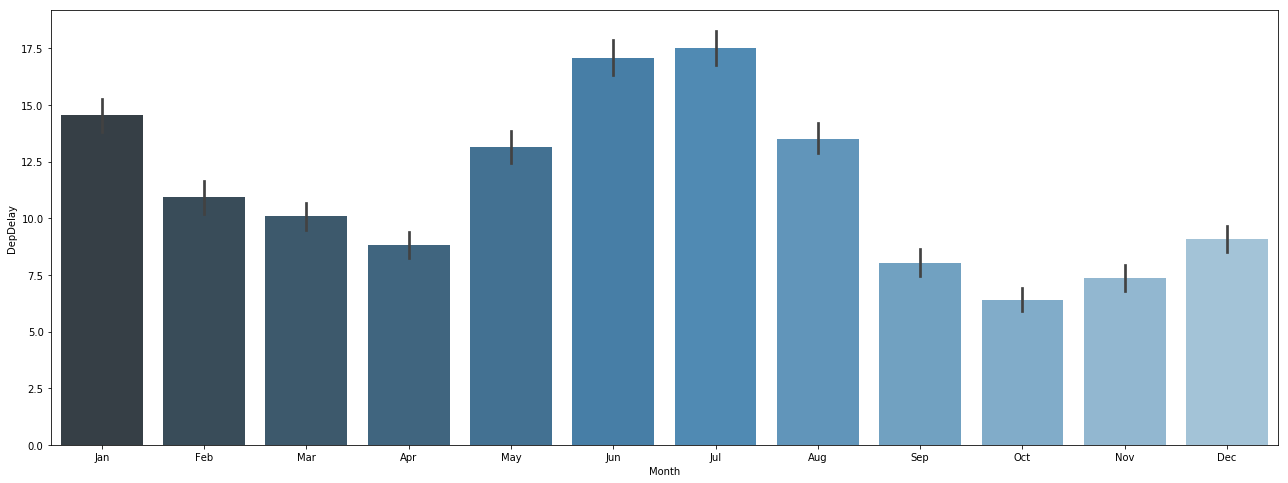

In [37]:
plt.figure(figsize=(22,8))
ax = sns.barplot(x="Month", y="DepDelay", data=df, order=['Jan','Feb','Mar',
                        'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], palette="Blues_d")

### And there is some difference based on the destination airport.  It looks like people traveling to Trenton-Mercer Airport from Dulles may have trouble with delays

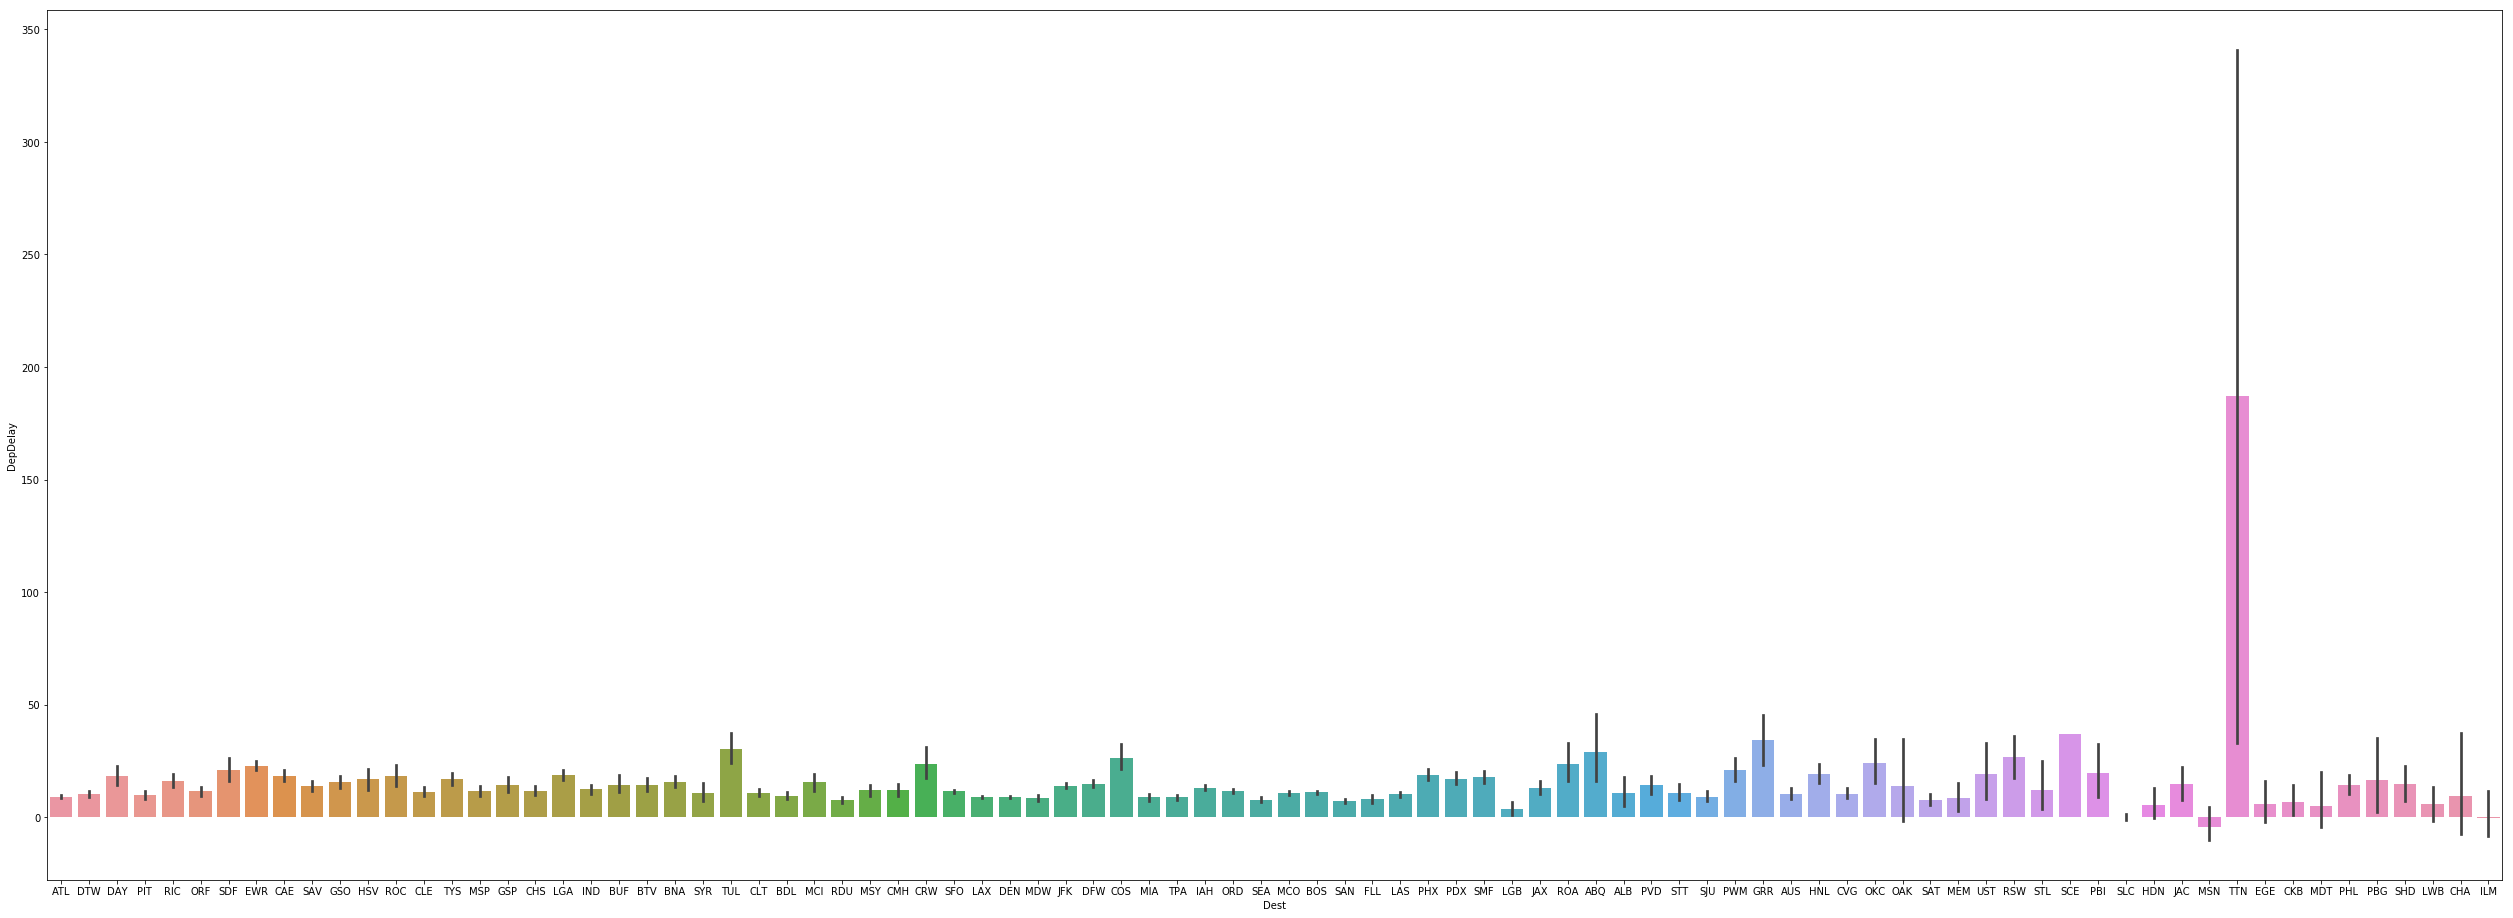

In [38]:
plt.figure(figsize=(44,16))
ax = sns.barplot(x="Dest", y="DepDelay", data=df)

In [39]:
df.groupby('DepTimeBlk').mean().DepDelay

DepTimeBlk
0001-0559     3.485605
0600-0659     2.985662
0700-0759     4.755826
0800-0859     5.987318
0900-0959     5.283450
1000-1059     7.696952
1100-1159     6.430575
1200-1259     9.871543
1300-1359     9.859906
1400-1459    10.816738
1500-1559    10.072132
1600-1659    17.413961
1700-1759    17.174349
1800-1859    18.856439
1900-1959    16.469432
2000-2059    19.994300
2100-2159    18.019472
2200-2259    12.537801
2300-2359    -5.500000
Name: DepDelay, dtype: float64

### It also appears that flights backup during the day and then catch back up overnight.  Here is a graph of the delay based on the time of day that the flight was scheduled to depart.  

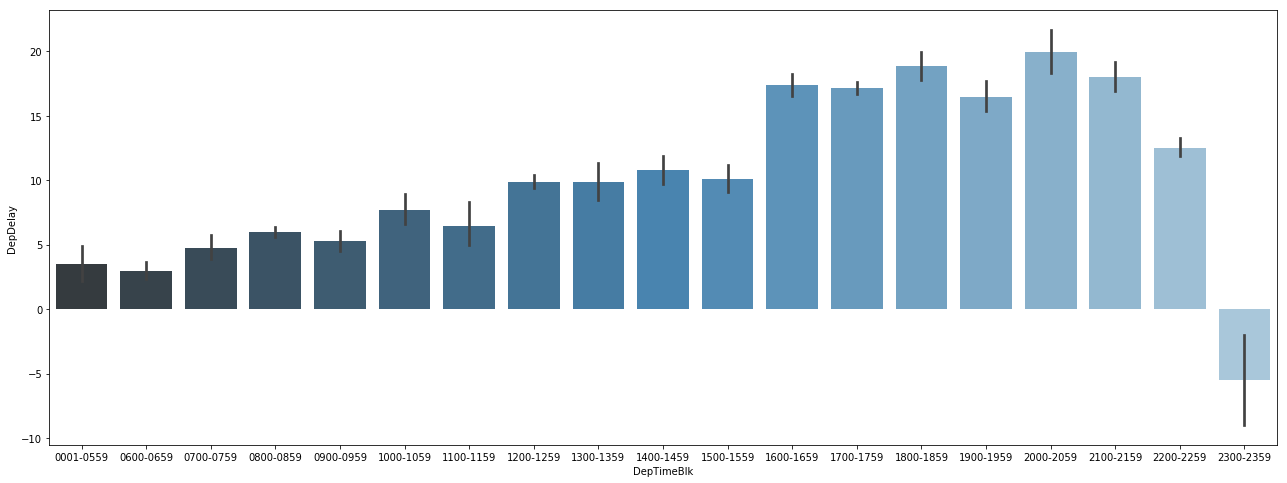

In [40]:
time_order = df.groupby('DepTimeBlk').mean().DepDelay.index
plt.figure(figsize=(22,8))
ax = sns.barplot(x="DepTimeBlk", y="DepDelay", data=df, order=time_order, palette="Blues_d")

Airline Codes:
- 9E = Endeavor Air
- AA = American Airlines
- AS = Alaska Airlines
- B6 = Jetblue Airways
- DL = Delta Air Lines 
- EV = ExpressJet Airlines
- F9 = Frontier Airlines
- OH = PSA Airlines (US Airways Express)
- OO = SkyWest Airlines
- UA = United Airlines
- VX = Virgin America
- WN = Southwest Airlines
- YV = Mesa Airlines
- YX = Republic Airways

In [41]:
df.groupby('Reporting_Airline').count().DepDelay.sort_values(ascending=False)

Reporting_Airline
UA    108977
EV     26662
YV     22945
AA     13472
DL     13282
WN     11477
B6     10031
VX      6660
F9      6046
OO      4812
AS      2546
OH      2263
9E      1244
YX       302
Name: DepDelay, dtype: int64

### United Airlines has the most flights departing Dulles over the past 5 years.  Will that impact their departure delays?

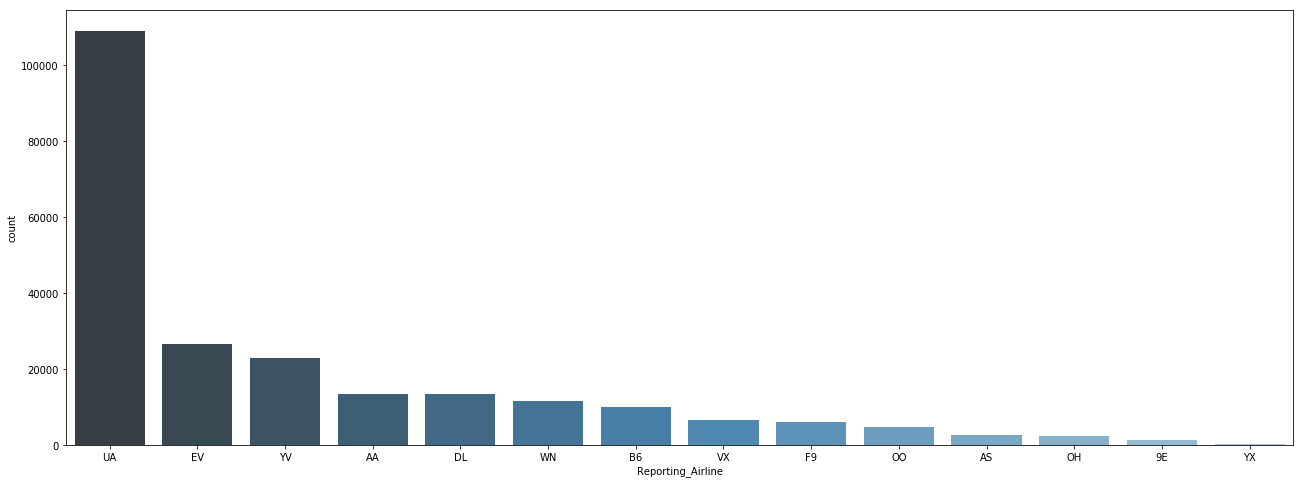

In [42]:
my_order = list(df.groupby('Reporting_Airline').count().DepDelay.sort_values(ascending=False).index)
plt.figure(figsize=(22,8))
ax = sns.countplot(x="Reporting_Airline", data=df, order=my_order, palette="Blues_d")

In [43]:
df.groupby('Reporting_Airline').mean().DepDelay.sort_values()

Reporting_Airline
YX    -0.089404
AS     3.802042
DL     6.857928
VX     8.001802
WN     8.400627
OH     9.605391
YV    10.662672
UA    10.806904
B6    11.605822
AA    12.197966
9E    12.624598
OO    14.527847
F9    16.493880
EV    18.090691
Name: DepDelay, dtype: float64

### The different airlines do seem to have a variety of departure delays.  Here are the departure delays by airline.

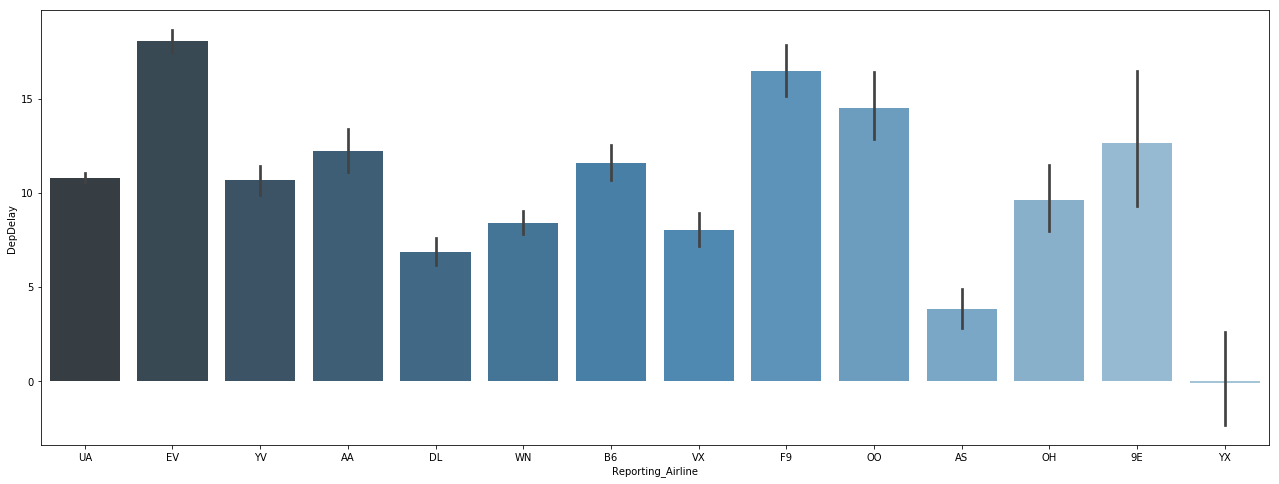

In [44]:
plt.figure(figsize=(22,8))
ax = sns.barplot(x="Reporting_Airline", y="DepDelay", data=df, order=my_order, palette="Blues_d")

### Interestingly, the tail numbers are included in the data.  Although it doesn't seem resonable to predict delay based on tail number as they could be switched at the last minute, I was curious to see if there were "problem aircraft" based on tail number.

### Here are the 20 most frequently used aircraft over the past 5 years out of Dulles

In [45]:
num_flights = df['Tail_Number'].value_counts().nlargest(20)
num_flights

N519LR    978
N835AS    974
N515MJ    945
N834AS    942
N836AS    934
N514MJ    925
N512MJ    905
N509MJ    895
N511MJ    887
N516LR    885
N518LR    882
N832AS    866
N513MJ    859
N510MJ    852
N521LR    849
N820AS    831
N833AS    820
N827AS    812
N504MJ    810
N508MJ    801
Name: Tail_Number, dtype: int64

In [46]:
df_tails = df[df['Tail_Number'].isin(list(num_flights.index))]

### This graph shows the number of flights that have left Dulles for each aircraft over the past 5 years

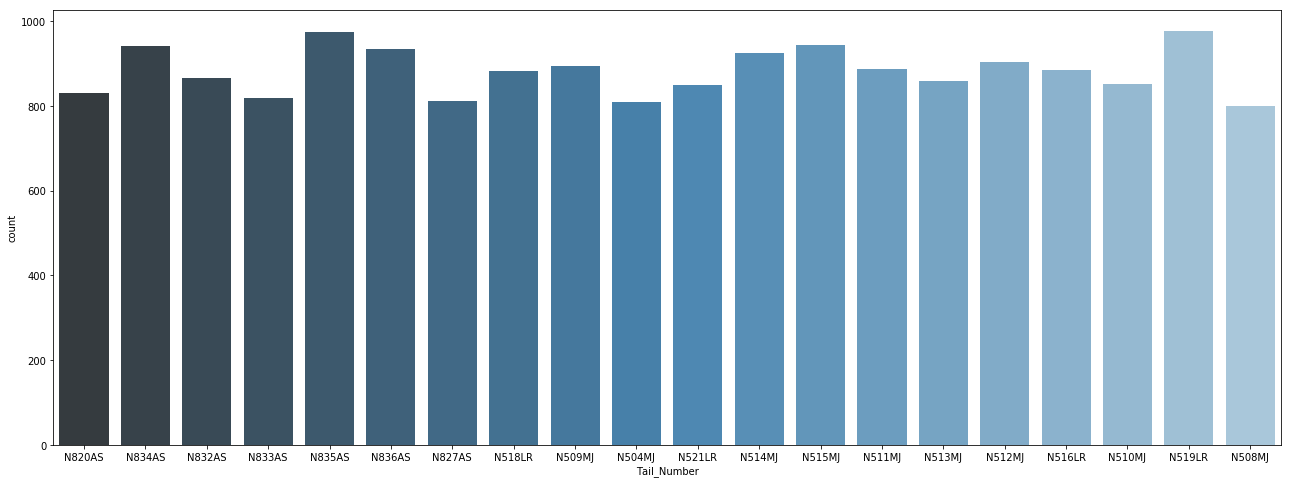

In [47]:
plt.figure(figsize=(22,8))
ax = sns.countplot(x='Tail_Number', data=df_tails, palette="Blues_d")

In [48]:
df[df['Tail_Number'].isin(list(df['Tail_Number'].value_counts().nlargest(20).index))].groupby('Tail_Number').mean().DepDelay.sort_values()

Tail_Number
N514MJ     6.391351
N510MJ     6.539906
N508MJ     7.649189
N521LR     7.686690
N513MJ     8.291036
N511MJ     8.347238
N504MJ     9.756790
N512MJ    10.238674
N515MJ    10.532275
N516LR    10.824859
N519LR    11.303681
N509MJ    11.436872
N518LR    12.337868
N835AS    15.385010
N820AS    17.992780
N827AS    18.383005
N832AS    18.698614
N836AS    18.906852
N834AS    19.529724
N833AS    20.534146
Name: DepDelay, dtype: float64

### And this shows the average departure delay for each aircraft over the past 5 years.  There is much more variance than I expected.  

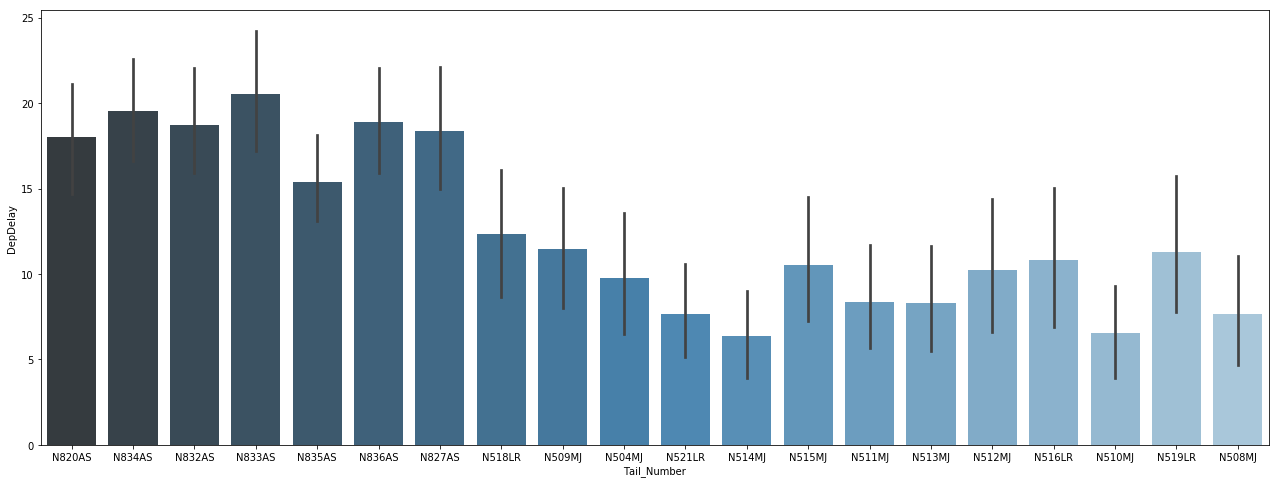

In [49]:
plt.figure(figsize=(22,8))
ax = sns.barplot(x='Tail_Number', y='DepDelay', data=df_tails, palette="Blues_d")

### I want to take a deeper dive comparing the aircraft on our list with the longest average delay versus the aircraft on our list with the shortest delay

### I anticipated that the aircraft with the longer average delay would have more very long delays, but the data doesn't seem to be supporting that data

In [50]:
df[df['Tail_Number'] == 'N833AS']['DepDelay'].nlargest(20)

3075     339.0
2461     327.0
4086     303.0
68352    296.0
5198     287.0
4090     278.0
31411    278.0
32832    271.0
39026    257.0
7844     228.0
2182     215.0
56888    214.0
10653    208.0
19586    207.0
29795    198.0
31463    197.0
51716    192.0
31467    190.0
21742    188.0
58713    188.0
Name: DepDelay, dtype: float64

In [51]:
df[df['Tail_Number'] == 'N514MJ']['DepDelay'].nlargest(20)

211893    576.0
229599    355.0
227083    344.0
216301    292.0
175117    256.0
224801    216.0
211262    213.0
229439    204.0
192952    198.0
225906    195.0
217074    193.0
196961    160.0
211083    146.0
218485    142.0
204793    137.0
180008    134.0
211304    129.0
216459    129.0
178480    125.0
220856    120.0
Name: DepDelay, dtype: float64

# Statistical Analysis

### Lets use some statistical tools to look at the two aircraft from above.  Here is some general data on their delays.

In [52]:
df[df['Tail_Number']=='N833AS'].DepDelay.describe()

count    820.000000
mean      20.534146
std       51.243655
min      -14.000000
25%       -5.000000
50%       -1.000000
75%       20.000000
max      339.000000
Name: DepDelay, dtype: float64

In [53]:
df[df['Tail_Number']=='N514MJ'].DepDelay.describe()

count    925.000000
mean       6.391351
std       39.311916
min      -15.000000
25%       -6.000000
50%       -4.000000
75%        0.000000
max      576.000000
Name: DepDelay, dtype: float64

A histogram gives a better feel for the Departure Delays data.  After taking a look, it seems they aren't too far off of one another.  Could it be random chance that N833AS has a higher departure delays than N514MJ?  We will find out with some statistical analysis.  

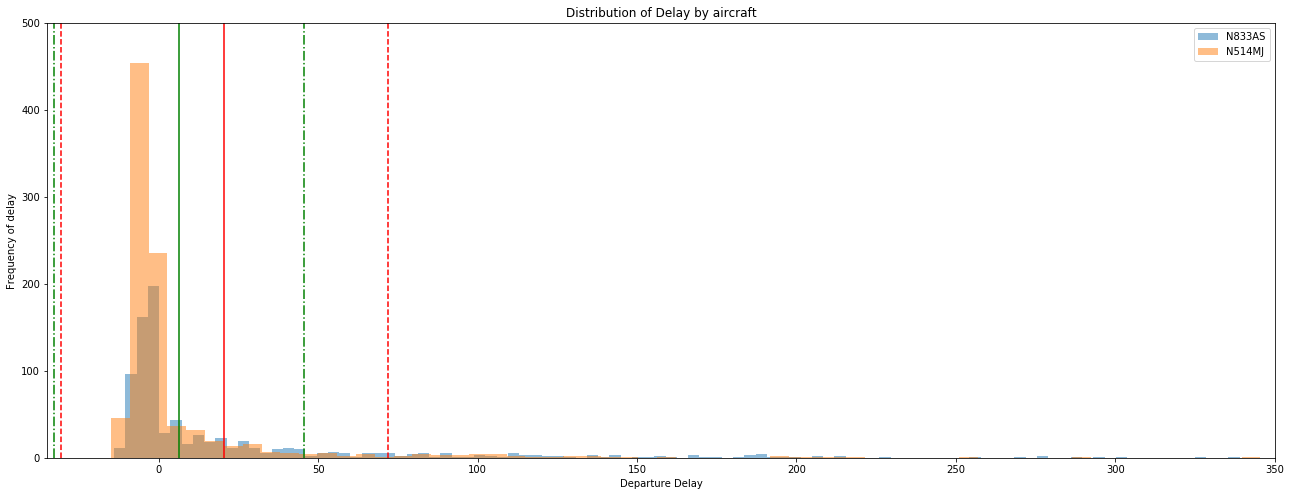

In [54]:
_ = plt.figure(figsize=(22,8))
_ = plt.hist(df[df['Tail_Number']=='N833AS'].DepDelay, bins=100, alpha=0.5, label='N833AS')
_ = plt.hist(df[df['Tail_Number']=='N514MJ'].DepDelay, bins=100, alpha=0.5, label='N514MJ')
_ = plt.xlabel('Departure Delay')
_ = plt.ylabel('Frequency of delay')
_ = plt.title('Distribution of Delay by aircraft')
_ = plt.legend()
_ = plt.xlim([-35,350])
_ = plt.ylim([0,500])
_ = plt.axvline(20.534146, color='r')
_ = plt.axvline(20.534146+51.243655, color='r', linestyle='--')
_ = plt.axvline(20.534146-51.243655, color='r', linestyle='--')
_ = plt.axvline(6.391351, color='g')
_ = plt.axvline(6.391351+39.311916, color='g', linestyle='-.')
_ = plt.axvline(6.391351-39.311916, color='g', linestyle='-.')

In [55]:
# Narrow the dataframe down to just the Loan Status and Annual Income
df_tail_delay_nan = df[['Tail_Number','DepDelay']]
# Drop any rows that do not include an annual income
df_tail_delay = df_tail_delay_nan.dropna().reset_index(drop=True)
df_tail_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230719 entries, 0 to 230718
Data columns (total 2 columns):
Tail_Number    230719 non-null object
DepDelay       230719 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.5+ MB


In [56]:
# Make an array for each tail number
N833AS_delays = df_tail_delay[(df_tail_delay['Tail_Number']=='N833AS')].DepDelay
N514MJ_delays = df_tail_delay[(df_tail_delay['Tail_Number']=='N514MJ')].DepDelay

One more visual for the departure delays.  An Empirical Cumulative Distribution Function (ECDF) is a good alternative to a historgram.  They shows the proportion of scores that are less than or equal to each score.  Again, you can see that the two groups are close but not the same.  

In [57]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

In [58]:
x_N833,y_N833 = ecdf(N833AS_delays)
x_N514,y_N514 = ecdf(N514MJ_delays)

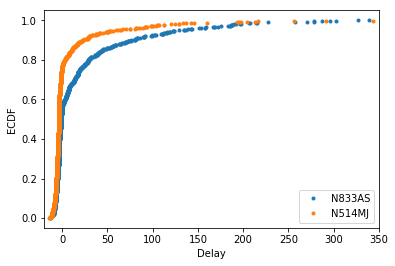

In [59]:
# Generate plot
_ = plt.plot(x_N833,y_N833,marker = '.',linestyle = 'none')
_ = plt.plot(x_N514,y_N514,marker = '.',linestyle = 'none')

# Label the axes
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Delay')

# Limit the x-axis so we can see the most relevant data
_ = plt.xlim([-20,350])

plt.legend(('N833AS', 'N514MJ'), loc='lower right')

# Display the plot
plt.show()

In order to analyze the data we will need to make a null hypothesis and then test that hypothesis.  We will hypothesize that Tail Number has no effect on the departure delays.  In our case, the null hypothesis will state that there is no difference between the departure delays of the two aircraft. 

To test our null hypothesis we will take all of the incomes of both populations, randomize them, and then split them back up into two groups.  If there is no difference between the two original groups then our new groups will behave the same way as our original groups.  

We will create functions that can randomize the data from the two groups and then split that data back into two new groups.  We then determine if there is a difference in the average of those two groups. 

In [60]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1,data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [61]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [62]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff


Using our new functions we will perform this process 10,000 times to see how likely it is that the result we saw could happen if the null hypothesis were true.  

In [63]:
# Compute difference of mean from sample data: empirical_diff_means
empirical_diff_means = diff_of_means(N833AS_delays,N514MJ_delays)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(N833AS_delays,N514MJ_delays,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0


We have a p-value very close to zero. The histgram below gives a visual representation of the distribution of our data based on the null hypothesis (the blue peak) and the empirical value (the red line). 

C:\Users\Scott\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


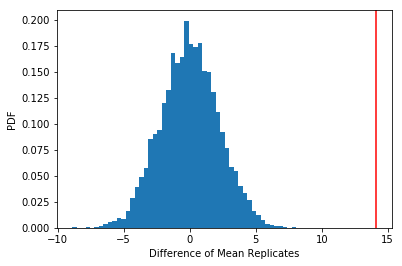

In [64]:
# Make a histogram of the results
_ = plt.hist(perm_replicates, bins=50, normed=True)
_ = plt.xlabel('Difference of Mean Replicates')
_ = plt.ylabel('PDF')
_ = plt.axvline(empirical_diff_means, color='r')

# Show the plot
plt.show()

Now we will build a confidence interval.  It will tell us, with 95% confidence, what is the difference between the average income of the Charged Off/Default loan population and the Full Paid loan population.  

We build two function to randomly sample the data from each group individually and then take the difference of the average of the two groups.  

In [65]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [66]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

Get the empirical difference between the two means.

In [67]:
mean_diff =  np.mean(N833AS_delays) - np.mean(N514MJ_delays)

Run the functions 10,000 times each.  

In [68]:
bs_replicates_N833 = draw_bs_reps(N833AS_delays,np.mean,10000)
bs_replicates_N514 = draw_bs_reps(N514MJ_delays,np.mean,10000)

In [69]:
bs_diff_replicates = bs_replicates_N833 - bs_replicates_N514

In [70]:
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

In [71]:
print('difference of means =', mean_diff, '$')
print('95% confidence interval =', conf_int, '$')

difference of means = 14.142794990112064 $
95% confidence interval = [ 9.8060496 18.4805061] $


### We can now say with 95% confidence that the N514MJ did not have a shorter average departure delay then N833AS by random chance.  

C:\Users\Scott\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


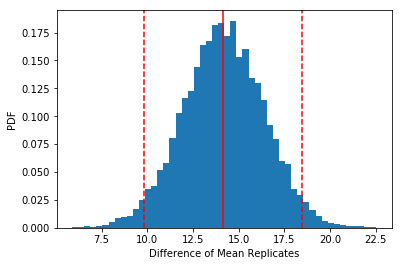

In [72]:
# Make a histogram of the results
_ = plt.hist(bs_diff_replicates, bins=50, normed=True)
_ = plt.xlabel('Difference of Mean Replicates')
_ = plt.ylabel('PDF')
_ = plt.axvline(mean_diff, color='r')
_ = plt.axvline(conf_int[0], color='r', linestyle='--')
_ = plt.axvline(conf_int[1], color='r', linestyle='--')

# Show the plot
plt.show()

# Machine Learning

In [73]:
df_copy = df.copy()

In [74]:
#df = df_copy.copy()

In [75]:
df.head()

,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,Origin,OriginState,Dest,DestState,DepDelay,DepTimeBlk,CRSElapsedTime,Distance,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,Jan,27,Monday,2014-01-27,DL,N989DL,301,IAD,VA,ATL,GA,-2.0,0900-0959,114.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jan,27,Monday,2014-01-27,DL,N343NB,1697,IAD,VA,ATL,GA,70.0,0700-0759,116.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jan,27,Monday,2014-01-27,DL,N919DL,2015,IAD,VA,ATL,GA,-4.0,1600-1659,114.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Jan,27,Monday,2014-01-27,DL,N906DL,2260,IAD,VA,ATL,GA,-3.0,1800-1859,116.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Jan,27,Monday,2014-01-27,DL,N972DL,1125,IAD,VA,ATL,GA,-2.0,1400-1459,112.0,534.0,2014-01-27,14.32,0.0,0.0,2.0,31,46,18,330,330.0,31.1,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
drop_list = ['FlightDate','DATE','OriginState','Origin','Tail_Number']
df = df.drop(drop_list, axis=1)

In [77]:
# This will show us how many null values we have in each column
# That will tell us exactly which columns need to be cleaned-up
df.isnull().sum()

Month                              0
DayofMonth                         0
DayOfWeek                          0
Reporting_Airline                  0
Flight_Number_Reporting_Airline    0
Dest                               0
DestState                          0
DepDelay                           0
DepTimeBlk                         0
CRSElapsedTime                     0
Distance                           0
AWND                               0
PRCP                               0
SNOW                               0
SNWD                               0
TAVG                               0
TMAX                               0
TMIN                               0
WDF2                               0
WDF5                               0
WSF2                               0
WSF5                               0
WT01                               0
WT02                               0
WT03                               0
WT04                               0
WT05                               0
W

In [78]:
def heatMap(df, mirror=False):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(100, 100))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()

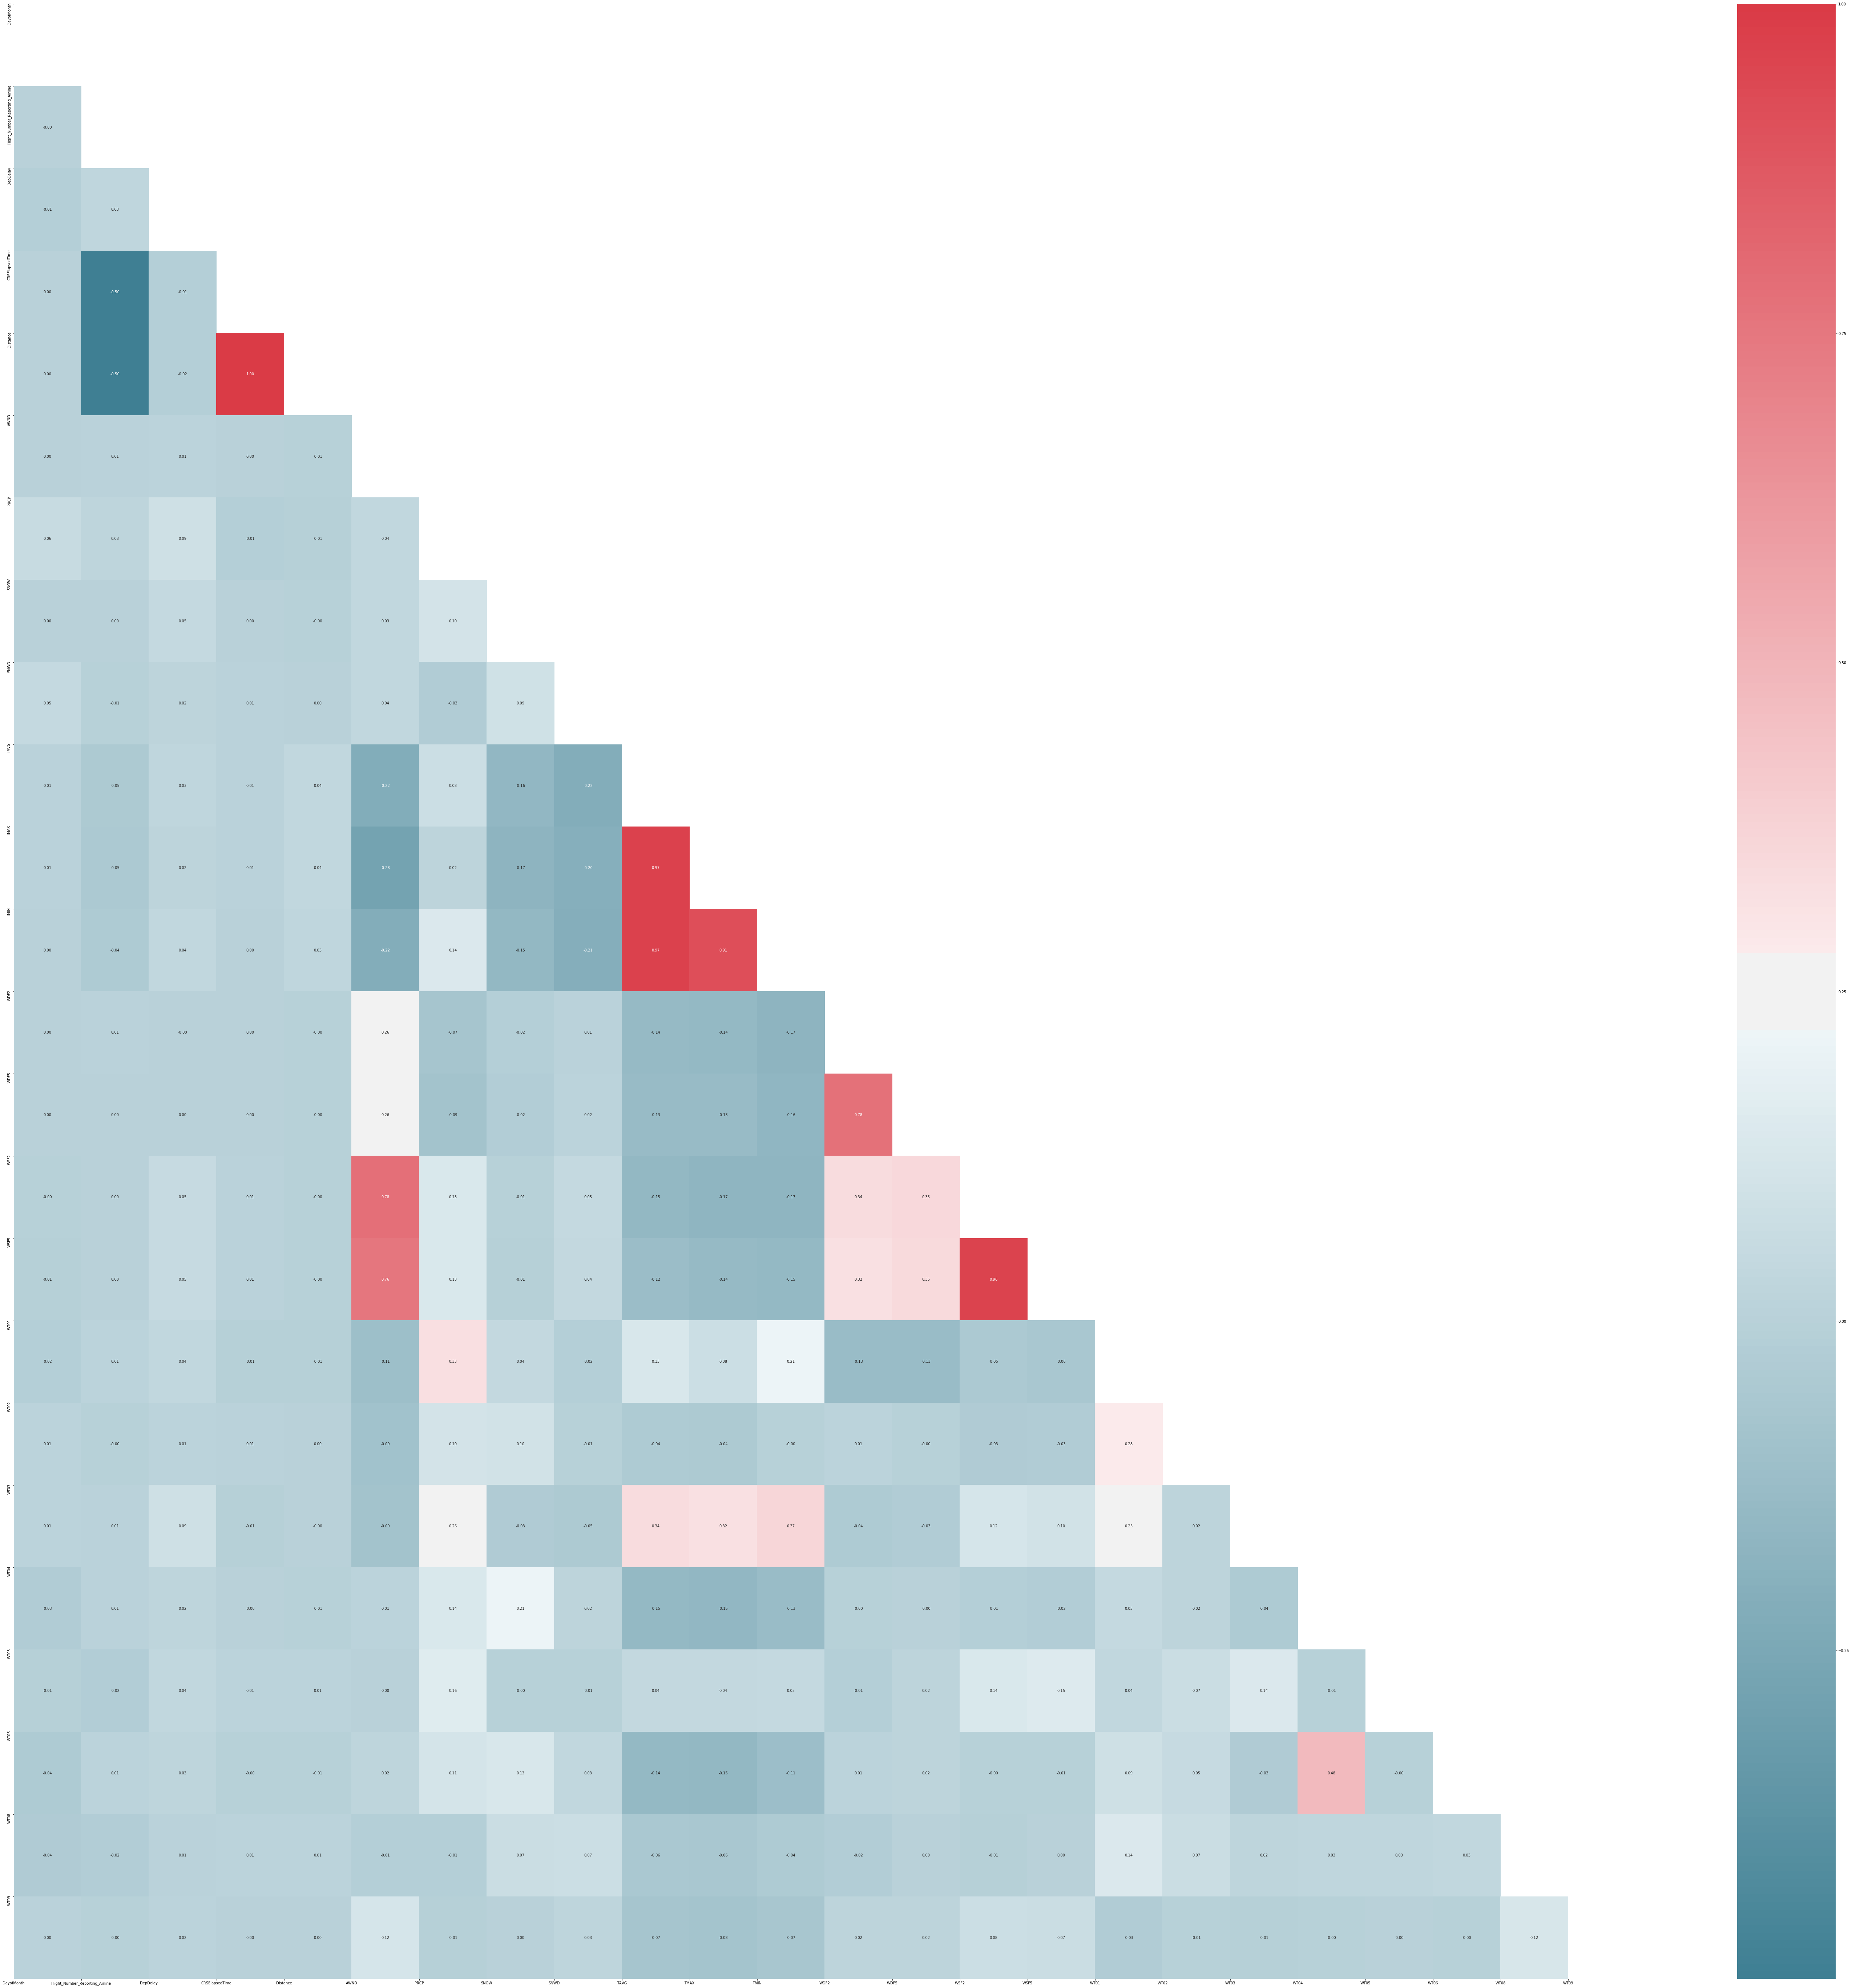

In [79]:
heatMap(df)

In [80]:
corr_drop_list = ['Distance','TMAX','TMIN','WSF2']
df = df.drop(corr_drop_list, axis=1)

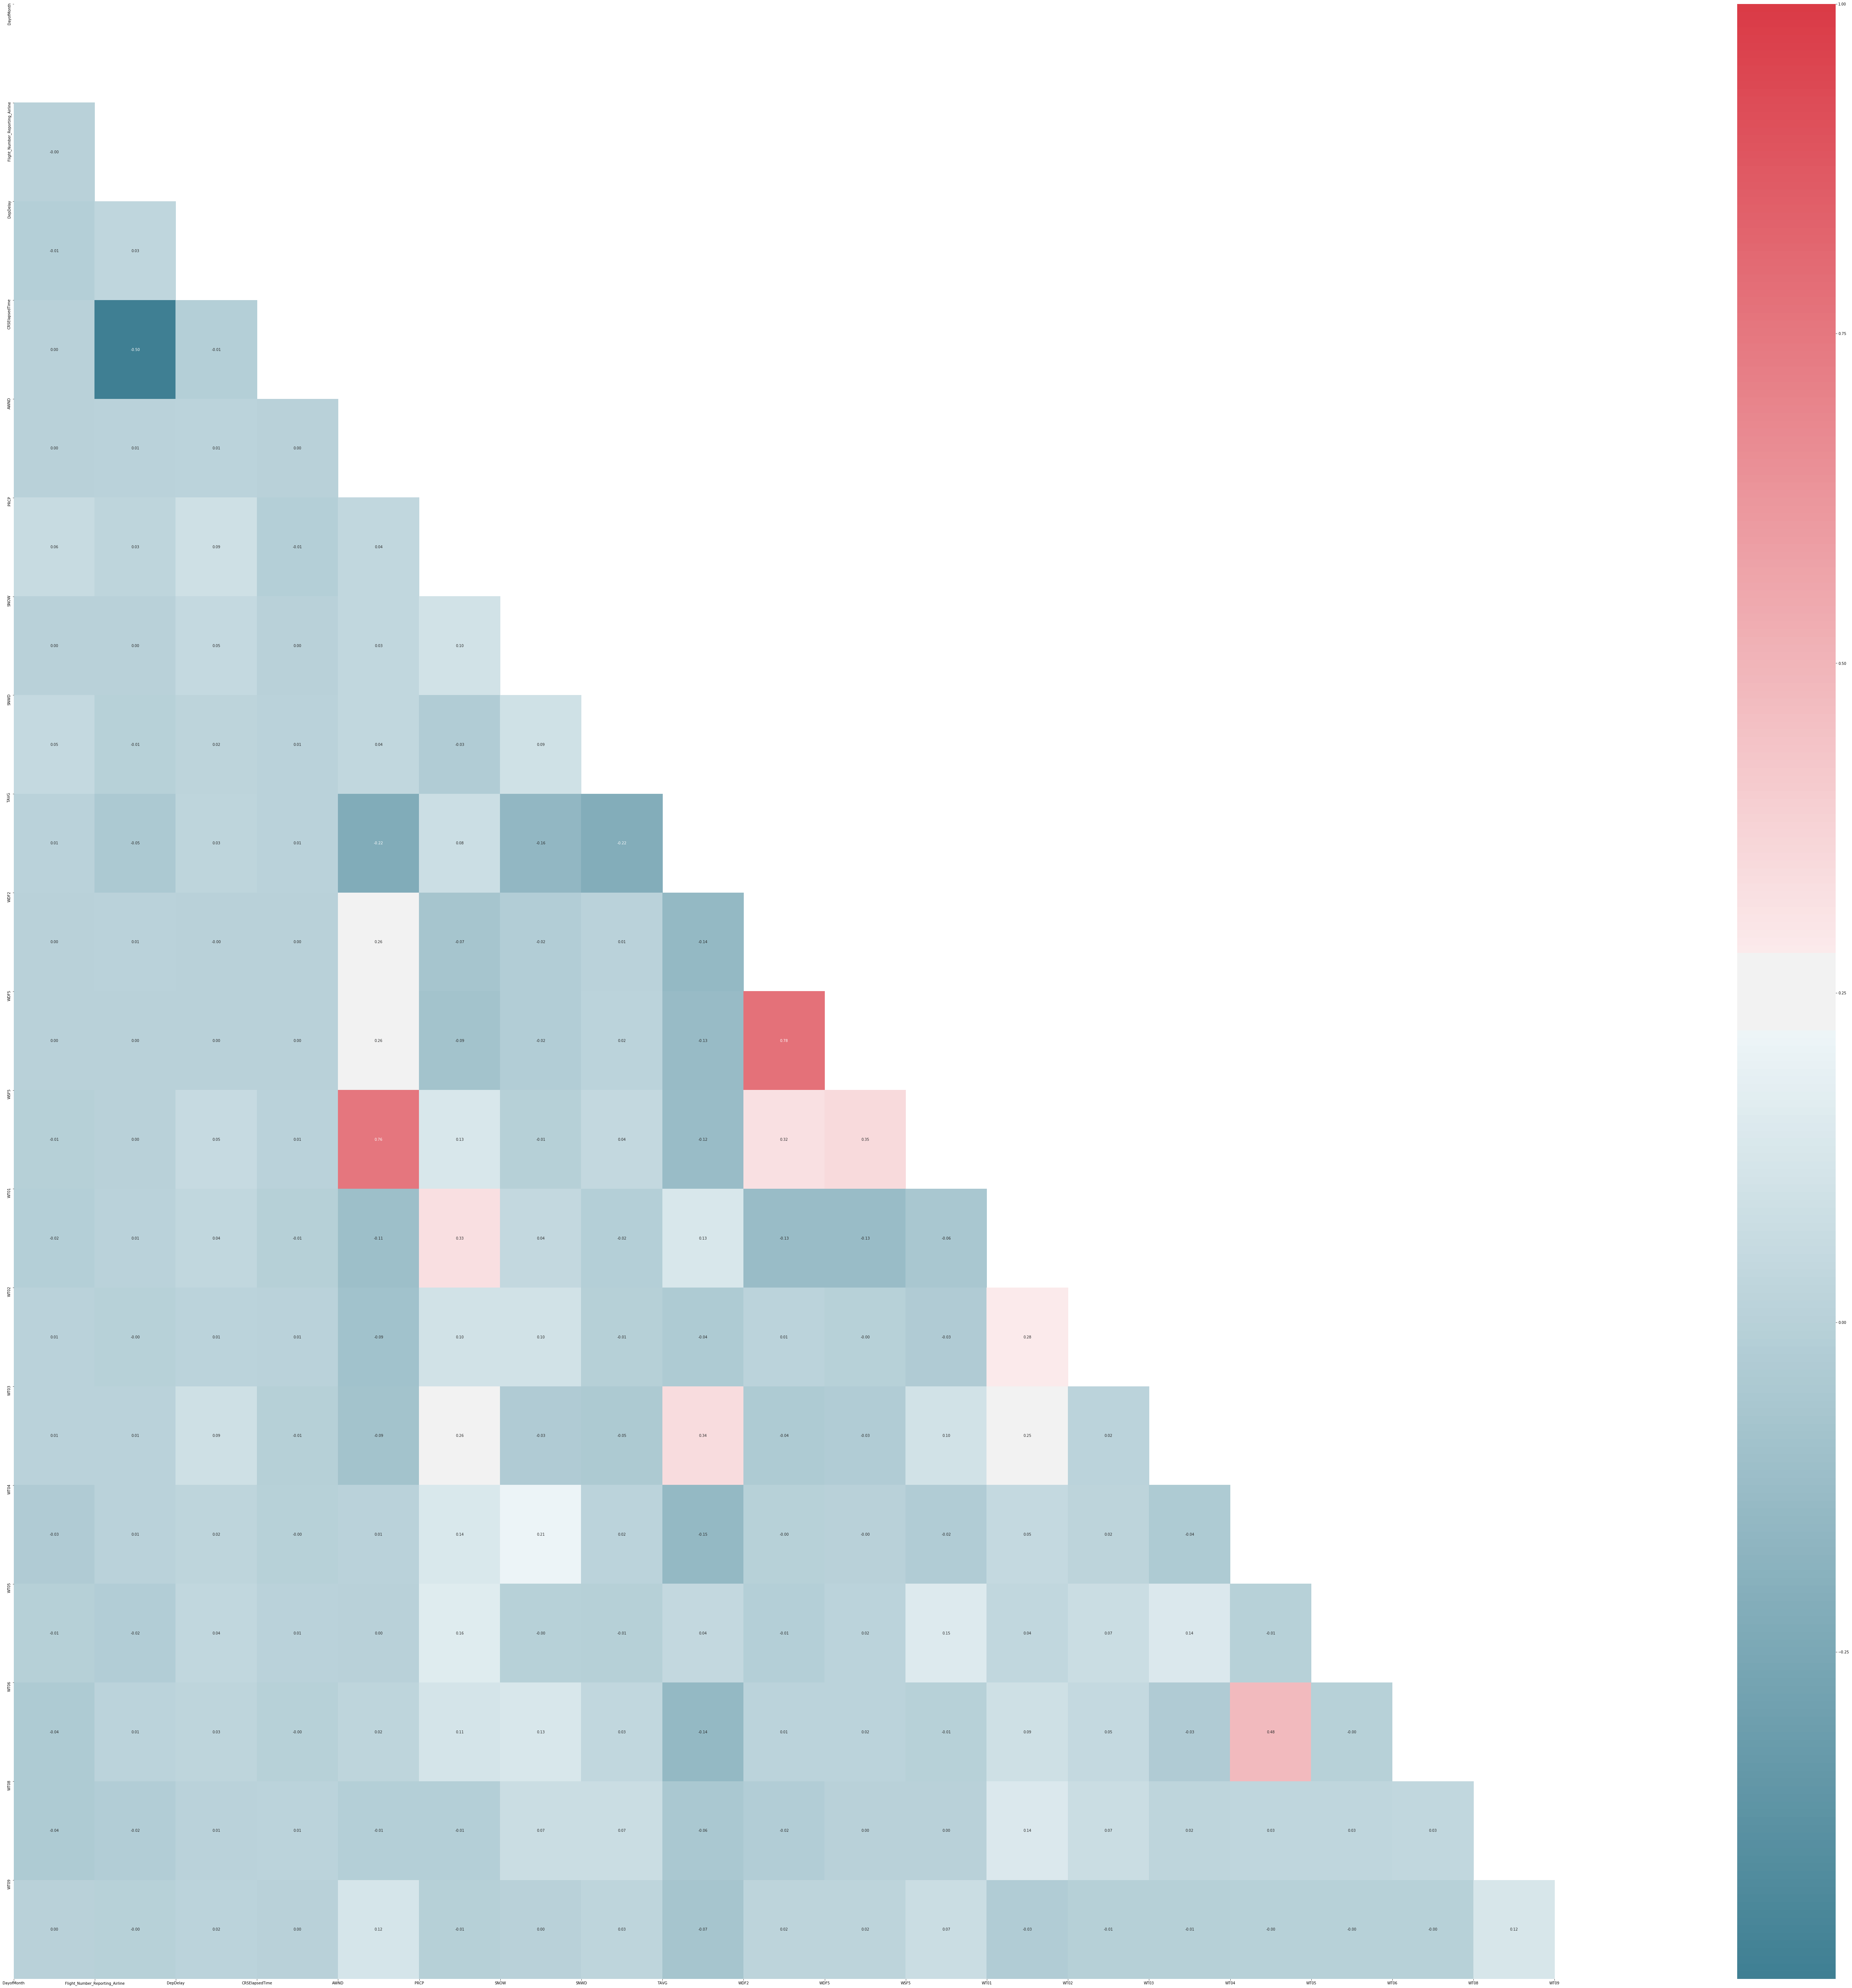

In [81]:
heatMap(df)

In [82]:
obj_list = sorted(list(df.select_dtypes(include=['object']).columns))
for i in range(len(obj_list)):
    print('column name:  ',obj_list[i])
    print('number of unique values:  ',len(df[obj_list[i]].unique()))
    print('unique values:  ')
    print(df[obj_list[i]].unique())
    print("--------------------------")

column name:   DayOfWeek
number of unique values:   7
unique values:  
['Monday' 'Friday' 'Sunday' 'Saturday' 'Wednesday' 'Thursday' 'Tuesday']
--------------------------
column name:   DepTimeBlk
number of unique values:   19
unique values:  
['0900-0959' '0700-0759' '1600-1659' '1800-1859' '1400-1459' '1200-1259'
 '1700-1759' '0800-0859' '2100-2159' '0600-0659' '2200-2259' '1500-1559'
 '1000-1059' '1100-1159' '1900-1959' '2000-2059' '1300-1359' '0001-0559'
 '2300-2359']
--------------------------
column name:   Dest
number of unique values:   88
unique values:  
['ATL' 'DTW' 'DAY' 'PIT' 'RIC' 'ORF' 'SDF' 'EWR' 'CAE' 'SAV' 'GSO' 'HSV'
 'ROC' 'CLE' 'TYS' 'MSP' 'GSP' 'CHS' 'LGA' 'IND' 'BUF' 'BTV' 'BNA' 'SYR'
 'TUL' 'CLT' 'BDL' 'MCI' 'RDU' 'MSY' 'CMH' 'CRW' 'SFO' 'LAX' 'DEN' 'MDW'
 'JFK' 'DFW' 'COS' 'MIA' 'TPA' 'IAH' 'ORD' 'SEA' 'MCO' 'BOS' 'SAN' 'FLL'
 'LAS' 'PHX' 'PDX' 'SMF' 'LGB' 'JAX' 'ROA' 'ABQ' 'ALB' 'PVD' 'STT' 'SJU'
 'PWM' 'GRR' 'AUS' 'HNL' 'CVG' 'OKC' 'OAK' 'SAT' 'MEM' 'UST' 'RS

In [83]:
# Pandas get_dummies does all of the heavy lifting for creating numeric columns and removing the object columns
df = pd.get_dummies(df, prefix_sep='_', drop_first=True)

In [84]:
df.head()

,DayofMonth,Flight_Number_Reporting_Airline,DepDelay,CRSElapsedTime,AWND,PRCP,SNOW,SNWD,TAVG,WDF2,WDF5,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Reporting_Airline_AA,Reporting_Airline_AS,Reporting_Airline_B6,Reporting_Airline_DL,Reporting_Airline_EV,Reporting_Airline_F9,Reporting_Airline_OH,Reporting_Airline_OO,Reporting_Airline_UA,Reporting_Airline_VX,Reporting_Airline_WN,Reporting_Airline_YV,Reporting_Airline_YX,Dest_ALB,Dest_ATL,Dest_AUS,Dest_BDL,Dest_BNA,Dest_BOS,Dest_BTV,Dest_BUF,Dest_CAE,Dest_CHA,Dest_CHS,Dest_CKB,Dest_CLE,Dest_CLT,Dest_CMH,Dest_COS,Dest_CRW,Dest_CVG,Dest_DAY,Dest_DEN,Dest_DFW,Dest_DTW,Dest_EGE,Dest_EWR,Dest_FLL,Dest_GRR,Dest_GSO,Dest_GSP,Dest_HDN,Dest_HNL,Dest_HSV,Dest_IAH,Dest_ILM,Dest_IND,Dest_JAC,Dest_JAX,Dest_JFK,Dest_LAS,Dest_LAX,Dest_LGA,Dest_LGB,Dest_LWB,Dest_MCI,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MIA,Dest_MSN,Dest_MSP,Dest_MSY,Dest_OAK,Dest_OKC,Dest_ORD,Dest_ORF,Dest_PBG,Dest_PBI,Dest_PDX,Dest_PHL,Dest_PHX,Dest_PIT,Dest_PVD,Dest_PWM,Dest_RDU,Dest_RIC,Dest_ROA,Dest_ROC,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SCE,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SHD,Dest_SJU,Dest_SLC,Dest_SMF,Dest_STL,Dest_STT,Dest_SYR,Dest_TPA,Dest_TTN,Dest_TUL,Dest_TYS,Dest_UST,DestState_AZ,DestState_CA,DestState_CO,DestState_CT,DestState_FL,DestState_GA,DestState_HI,DestState_IL,DestState_IN,DestState_KY,DestState_LA,DestState_MA,DestState_ME,DestState_MI,DestState_MN,DestState_MO,DestState_NC,DestState_NJ,DestState_NM,DestState_NV,DestState_NY,DestState_OH,DestState_OK,DestState_OR,DestState_PA,DestState_PR,DestState_RI,DestState_SC,DestState_TN,DestState_TX,DestState_UT,DestState_VA,DestState_VI,DestState_VT,DestState_WA,DestState_WI,DestState_WV,DestState_WY,DepTimeBlk_0600-0659,DepTimeBlk_0700-0759,DepTimeBlk_0800-0859,DepTimeBlk_0900-0959,DepTimeBlk_1000-1059,DepTimeBlk_1100-1159,DepTimeBlk_1200-1259,DepTimeBlk_1300-1359,DepTimeBlk_1400-1459,DepTimeBlk_1500-1559,DepTimeBlk_1600-1659,DepTimeBlk_1700-1759,DepTimeBlk_1800-1859,DepTimeBlk_1900-1959,DepTimeBlk_2000-2059,DepTimeBlk_2100-2159,DepTimeBlk_2200-2259,DepTimeBlk_2300-2359
0,27,301,-2.0,114.0,14.32,0.0,0.0,2.0,31,330,330.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,27,1697,70.0,116.0,14.32,0.0,0.0,2.0,31,330,330.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,27,2015,-4.0,114.0,14.32,0.0,0.0,2.0,31,330,330.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,27,2260,-3.0,116.0,14.32,0.0,0.0,2.0,31,330,330.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230719 entries, 0 to 230718
Columns: 193 entries, DayofMonth to DepTimeBlk_2300-2359
dtypes: float64(16), int64(4), uint8(173)
memory usage: 85.0 MB


In [86]:
df.to_csv('Data/Loan_preproc.csv')

In [87]:
#df = pd.read_csv('Data/Loan_preproc.csv',low_memory=False,index_col=0)

## Split the dataset into X and y datasets

In [88]:
# We pull the data from the dataframe for our target values as y
df_y = df['DepDelay']
df_y.head()

0    -2.0
1    70.0
2    -4.0
3    -3.0
4    -2.0
Name: DepDelay, dtype: float64

In [89]:
# Convert to numpy array and check the shape
y = df_y.to_numpy() 
y.shape

(230719,)

In [90]:
# Drop the target data from our dataframe
X_drop_list = ['DepDelay']
df_X = df.drop(X_drop_list, axis=1)
df_X.head()

,DayofMonth,Flight_Number_Reporting_Airline,CRSElapsedTime,AWND,PRCP,SNOW,SNWD,TAVG,WDF2,WDF5,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Reporting_Airline_AA,Reporting_Airline_AS,Reporting_Airline_B6,Reporting_Airline_DL,Reporting_Airline_EV,Reporting_Airline_F9,Reporting_Airline_OH,Reporting_Airline_OO,Reporting_Airline_UA,Reporting_Airline_VX,Reporting_Airline_WN,Reporting_Airline_YV,Reporting_Airline_YX,Dest_ALB,Dest_ATL,Dest_AUS,Dest_BDL,Dest_BNA,Dest_BOS,Dest_BTV,Dest_BUF,Dest_CAE,Dest_CHA,Dest_CHS,Dest_CKB,Dest_CLE,Dest_CLT,Dest_CMH,Dest_COS,Dest_CRW,Dest_CVG,Dest_DAY,Dest_DEN,Dest_DFW,Dest_DTW,Dest_EGE,Dest_EWR,Dest_FLL,Dest_GRR,Dest_GSO,Dest_GSP,Dest_HDN,Dest_HNL,Dest_HSV,Dest_IAH,Dest_ILM,Dest_IND,Dest_JAC,Dest_JAX,Dest_JFK,Dest_LAS,Dest_LAX,Dest_LGA,Dest_LGB,Dest_LWB,Dest_MCI,Dest_MCO,Dest_MDT,Dest_MDW,Dest_MEM,Dest_MIA,Dest_MSN,Dest_MSP,Dest_MSY,Dest_OAK,Dest_OKC,Dest_ORD,Dest_ORF,Dest_PBG,Dest_PBI,Dest_PDX,Dest_PHL,Dest_PHX,Dest_PIT,Dest_PVD,Dest_PWM,Dest_RDU,Dest_RIC,Dest_ROA,Dest_ROC,Dest_RSW,Dest_SAN,Dest_SAT,Dest_SAV,Dest_SCE,Dest_SDF,Dest_SEA,Dest_SFO,Dest_SHD,Dest_SJU,Dest_SLC,Dest_SMF,Dest_STL,Dest_STT,Dest_SYR,Dest_TPA,Dest_TTN,Dest_TUL,Dest_TYS,Dest_UST,DestState_AZ,DestState_CA,DestState_CO,DestState_CT,DestState_FL,DestState_GA,DestState_HI,DestState_IL,DestState_IN,DestState_KY,DestState_LA,DestState_MA,DestState_ME,DestState_MI,DestState_MN,DestState_MO,DestState_NC,DestState_NJ,DestState_NM,DestState_NV,DestState_NY,DestState_OH,DestState_OK,DestState_OR,DestState_PA,DestState_PR,DestState_RI,DestState_SC,DestState_TN,DestState_TX,DestState_UT,DestState_VA,DestState_VI,DestState_VT,DestState_WA,DestState_WI,DestState_WV,DestState_WY,DepTimeBlk_0600-0659,DepTimeBlk_0700-0759,DepTimeBlk_0800-0859,DepTimeBlk_0900-0959,DepTimeBlk_1000-1059,DepTimeBlk_1100-1159,DepTimeBlk_1200-1259,DepTimeBlk_1300-1359,DepTimeBlk_1400-1459,DepTimeBlk_1500-1559,DepTimeBlk_1600-1659,DepTimeBlk_1700-1759,DepTimeBlk_1800-1859,DepTimeBlk_1900-1959,DepTimeBlk_2000-2059,DepTimeBlk_2100-2159,DepTimeBlk_2200-2259,DepTimeBlk_2300-2359
0,27,301,114.0,14.32,0.0,0.0,2.0,31,330,330.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,27,1697,116.0,14.32,0.0,0.0,2.0,31,330,330.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,27,2015,114.0,14.32,0.0,0.0,2.0,31,330,330.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,27,2260,116.0,14.32,0.0,0.0,2.0,31,330,330.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [91]:
# Convert to numpy array and check the shape
X = df_X.to_numpy()
X.shape

(230719, 192)

## Scale the X data

Some machine learning algorithms will be biased based on the size of the numbers in the columns.  Scaling the dataset prevents that bias.  

In [92]:
X_scaled = scale(X)

In [93]:
np.mean(X), np.std(X)

(15.467552926485613, 223.04724733749373)

In [94]:
np.mean(X_scaled), np.std(X_scaled)

(3.9424027512182074e-18, 1.0000000000000009)

### Let's split it into Testing and Training datasets
We want to split the data two times.  We want a dataset for training the models and selecting hyperparameters, then another dataset for testing which can be used to compare the models against one another, and then a final dataset for testing our slected model.  Since we need three groups of data we will split the data twice.  

In [95]:
X_int_train, X_final_test, y_int_train, y_final_test =train_test_split(X_scaled, y, test_size=0.2,random_state=1)

In [96]:
X_train, X_model_test, y_train, y_model_test =train_test_split(X_int_train, y_int_train, test_size=0.2,random_state=1)

# Machine Learning

We will fit on the training data and predict on the model test until we think we have the best possible model.  With that model we will test on the final testing dataset to get our results.  

## Ridge

In [97]:
np.logspace(-3, 9, 13)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09])

In [98]:
clf = RidgeCV(alphas=np.logspace(-3, 9, 13)).fit(X_train, y_train)

In [99]:
clf.alpha_

100.0

### Score for Ridge

In [100]:
clf.score(X_model_test,y_model_test)

0.032569638838831017

## Lasso

In [101]:
lasso = LassoCV(cv=5,max_iter=10000)
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [102]:
lasso.alphas_

array([4.33703218, 4.04473073, 3.77212942, 3.51790052, 3.2808058 ,
       3.05969047, 2.85347757, 2.66116273, 2.48180927, 2.31454363,
       2.15855114, 2.01307202, 1.8773977 , 1.75086738, 1.63286478,
       1.52281516, 1.42018251, 1.32446696, 1.23520232, 1.15195382,
       1.07431599, 1.00191069, 0.93438526, 0.87141082, 0.81268065,
       0.75790869, 0.70682818, 0.65919033, 0.61476311, 0.57333013,
       0.5346896 , 0.49865331, 0.46504575, 0.43370322, 0.40447307,
       0.37721294, 0.35179005, 0.32808058, 0.30596905, 0.28534776,
       0.26611627, 0.24818093, 0.23145436, 0.21585511, 0.2013072 ,
       0.18773977, 0.17508674, 0.16328648, 0.15228152, 0.14201825,
       0.1324467 , 0.12352023, 0.11519538, 0.1074316 , 0.10019107,
       0.09343853, 0.08714108, 0.08126806, 0.07579087, 0.07068282,
       0.06591903, 0.06147631, 0.05733301, 0.05346896, 0.04986533,
       0.04650457, 0.04337032, 0.04044731, 0.03772129, 0.03517901,
       0.03280806, 0.0305969 , 0.02853478, 0.02661163, 0.02481

In [103]:
lasso.alpha_

0.004337032184111448

### Score for Lasso

In [104]:
lasso.score(X_model_test,y_model_test)

0.03262277888569021

## K Neighbors Regression

I found this to be very computationally expensive.  I made a subset of the dataset to work on so it would finish.  

### KNR attempt 1

In [105]:
param_grid = {'n_neighbors': np.arange(12, 17)}
knn = KNeighborsRegressor()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train[0:10000], y_train[0:10000])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([12, 13, 14, 15, 16])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
knn_cv.best_params_

{'n_neighbors': 16}

### Score for KNR 1

In [107]:
knn_cv.score(X_model_test,y_model_test)

-0.02687615094828644

### KNR attempt 2

In [108]:
knn_2 = KNeighborsRegressor(n_neighbors=16)
knn_2.fit(X_train, y_train)
#knn_2.fit(X_train[0:100000], y_train[0:100000])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=16, p=2,
          weights='uniform')

### Score for KNR 2

In [109]:
knn_2.score(X_model_test,y_model_test)

0.0003181411738470974

## Support Vector Machine

In [110]:
np.logspace(-8, -4, 5)

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04])

In [111]:
param_grid = {'C': np.logspace(-8, -4, 5),
             'gamma': np.logspace(-9, -5, 5)}
svr = SVR()
svr_cv = RandomizedSearchCV(svr, param_grid, cv=3, iid=False, n_iter=10)
svr_cv.fit(X_train[0:10000], y_train[0:10000])

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=False, n_iter=10, n_jobs=None,
          param_distributions={'C': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04]), 'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [112]:
svr_cv.best_params_

{'gamma': 1e-05, 'C': 1e-07}

### Score for SVM

In [113]:
svr_cv.score(X_model_test,y_model_test)

-0.08333096172310239

## Support Vector Machine attempt 2

In [114]:
svr2 = SVR(C = 0.0001, gamma = 0.00001)
svr2.fit(X_train, y_train)

SVR(C=0.0001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-05,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Score for SVM 2

In [115]:
svr2.score(X_model_test,y_model_test)

-0.08087886892523954

## Random Forest attempt 1

In [116]:
np.linspace(start = 200, stop = 2000, num = 10)

array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
       2000.])

In [117]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features}

rfr=RandomForestRegressor()
rfr_cv = RandomizedSearchCV(rfr, param_grid, cv=3, n_iter=10) #GridSearchCV(svclassifier, param_grid, cv=5)
rfr_cv.fit(X_train[0:1000], y_train[0:1000])

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['log2', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [118]:
rfr_cv.best_params_

{'n_estimators': 1800, 'max_features': 'log2'}

### Score for Random Forest 1

In [119]:
rfr_cv.score(X_model_test,y_model_test)

-0.030084291884062253

## Random Forest attempt 2

In [120]:
max_features_2 = ['log2', 'sqrt']

param_grid_2 = {'max_features': max_features_2}

rfr_2=RandomForestRegressor(n_estimators=500)
rfr_cv_2 = GridSearchCV(rfr_2, param_grid_2, cv=3) #GridSearchCV(svclassifier, param_grid, cv=5)
rfr_cv_2.fit(X_train[0:10000], y_train[0:10000])

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': ['log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
rfr_cv_2.best_params_

{'max_features': 'log2'}

### Score for Random Forest 2

In [122]:
rfr_cv_2.score(X_model_test,y_model_test)

0.03450607505079051

## Random Forest attempt 3

In [123]:
rfr_3=RandomForestRegressor(n_estimators=500, max_features='log2')
rfr_3 = rfr_3.fit(X_train, y_train)   # rfc_3.fit(X_train[0:100000], y_train[0:100000])

### Score for Random Forest 3

In [124]:
rfr_3.score(X_model_test,y_model_test)

0.07601991536288799

## Catboost

In [125]:
model = CatBoostRegressor(
    random_seed=42,
    logging_level='Silent'
)

In [126]:
model.fit(
    X_train, y_train,
    eval_set=(X_model_test, y_model_test),
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Score for Catboost

In [127]:
model.score(X_model_test,y_model_test)

0.0637830421119403

# and the winner is Random Forest Regressor! 

Here are the results of the scoring:
1. 0.076 Random Forest
2. 0.064 Catboost
3. 0.033 Lasso
4. 0.033 Ridge
5. -0.004 K-Nearest Regression
6. -0.083 SVM

Random Forest Regressor was able to beat out CatBoost for the win.  The results are all very low and do not inspire much confidence.  It seems that more data would need to be pulled in to make better predictions.  I think adding tailnumber and information about the aircraft would create better results.    

### Final score of the Random Forest model on the last test set.

In [128]:
rfr_3.score(X_final_test,y_final_test)

0.0907577486146247